In [1]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import exploration_modules as expo
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)
importlib.reload(expo)

<module 'exploration_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\exploration_modules.py'>

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# set configuration
sample_size, nr_sample, nr_moments = 1000, 20, 6
n_folds = 5

## Bounded distributions

In [23]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [24]:
moments_df = dem.get_moments(bounded_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,m5,m6,label
0,0.491551,0.127754,0.001247,0.023949,0.000516,0.004981,arcsine
1,0.506075,0.129103,-0.001016,0.024293,-0.000388,0.005050,arcsine
2,0.475371,0.128239,0.004053,0.024465,0.001821,0.005222,arcsine


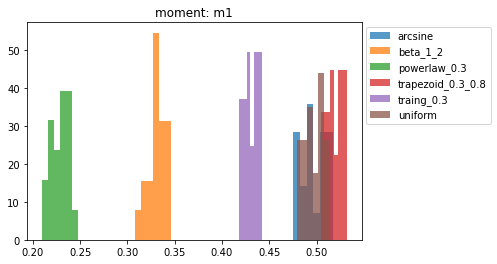

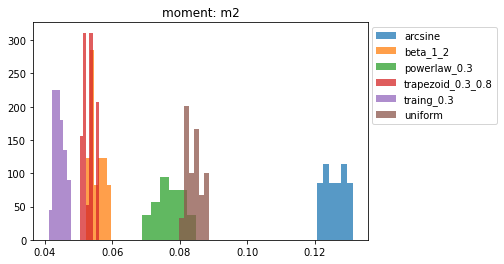

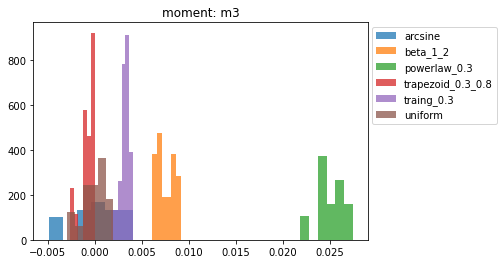

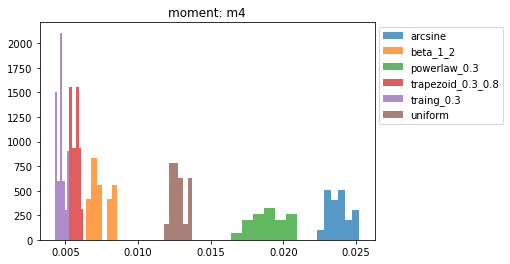

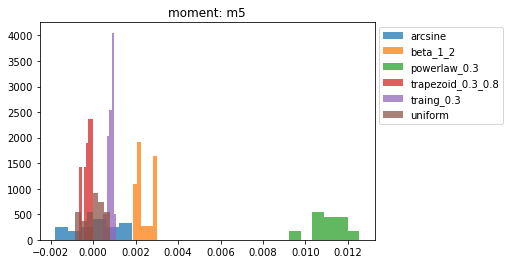

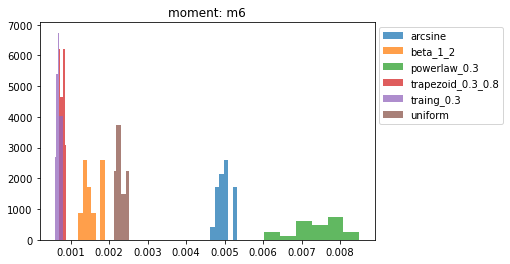

In [26]:
dem.get_histogram_of_moments(moments_df)

In [8]:
sample_size_list = [5, 10, 25, 50, 100, 500, 1000]
nr_moments_list = np.arange(2,21)

### svm

In [30]:
res_svm = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, bounded_dists, nr_sample, n_folds, 1)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [36]:
res_svm.to_csv('results/moments/res_svm_bounded.csv')

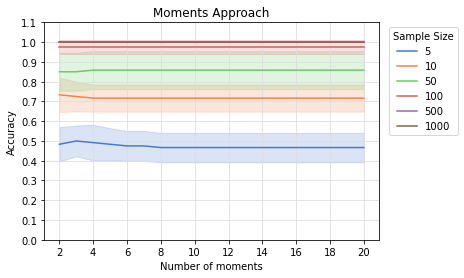

In [39]:
cm.plot_cv_moments(res_svm)

### Logistic Regression

In [10]:
res_lr = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, bounded_dists, nr_sample, n_folds, 2)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
res_lr.to_csv('results/moments/res_lr_bounded.csv')

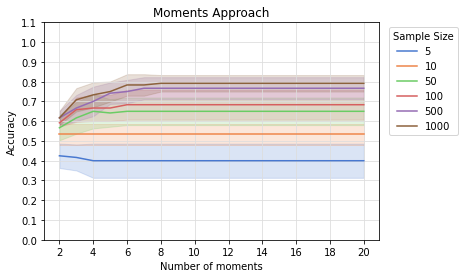

In [42]:
cm.plot_cv_moments(res_lr)

## Heavytail distributions

In [53]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples_t = dm.get_samples(heavytail_dists, nr_sample, sample_size, transform = True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [47]:
nr_moments=4
moments_df = dem.get_moments(heavytail_samples, nr_moments)
moments_df.head(3)

,m1,m2,m3,m4,label
0,4.193798,4.701566e+02,1.539614e+05,6.092631e+07,cauchy
1,68.162667,3.898993e+06,2.427691e+11,1.514418e+16,cauchy
2,4.331104,5.717557e+02,2.679574e+05,1.574834e+08,cauchy


(array([19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.70987390e+04, 2.42769218e+10, 4.85538266e+10, 7.28307313e+10,
        9.71076360e+10, 1.21384541e+11, 1.45661445e+11, 1.69938350e+11,
        1.94215255e+11, 2.18492160e+11, 2.42769064e+11]),
 <BarContainer object of 10 artists>)

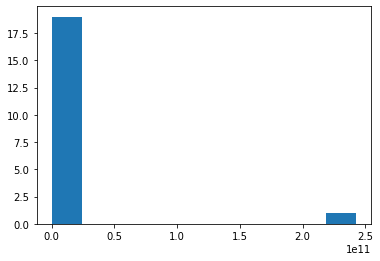

In [58]:
d1 = heavytail_samples_f.iloc[0:20,:]
moments_df = dem.get_moments(d1, nr_moments)
plt.hist(moments_df['m3'])

(array([2., 4., 5., 1., 0., 2., 3., 1., 1., 1.]),
 array([0.87677729, 1.02261439, 1.16845149, 1.31428858, 1.46012568,
        1.60596278, 1.75179988, 1.89763697, 2.04347407, 2.18931117,
        2.33514827]),
 <BarContainer object of 10 artists>)

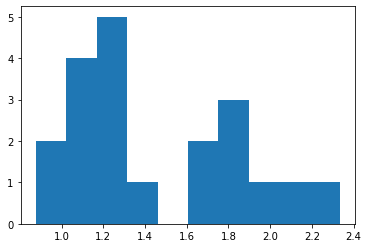

In [59]:
d2 = heavytail_samples_t.iloc[0:20,:]
moments_df_l = dem.get_moments(d2, nr_moments)
plt.hist(moments_df_l['m3'])

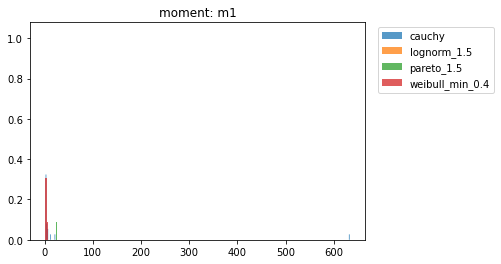

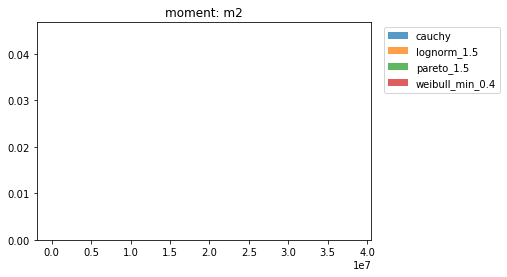

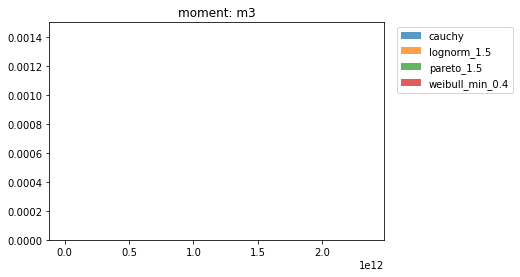

In [21]:
dem.get_histogram_of_moments(moments_df)

### SVM

In [44]:
res_svm_ht = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, heavytail_dists, nr_sample, n_folds, 1, transform = True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
res_svm_ht.to_csv('results/moments/res_svm_heavytail.csv')

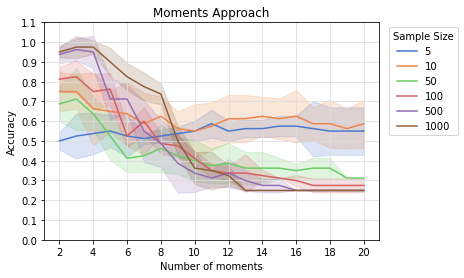

In [46]:
cm.plot_cv_moments(res_svm_ht)

### Logistic Regression

In [47]:
res_lr_ht = cm.cv_samplesize_moments(sample_size_list, nr_moments_list, heavytail_dists, nr_sample, n_folds, 2, transform=True)

Completed:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: RuntimeWarning: divide by zero encountered in true_divide
  squared_errors = (c / G_inverse_diag) ** 2
C:\Users\shfar\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1515: Runti

In [48]:
res_lr_ht.to_csv('results/moments/res_lr_heavytail.csv')

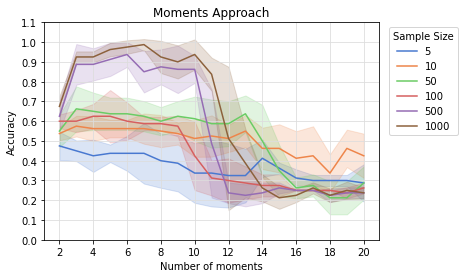

In [49]:
cm.plot_cv_moments(res_lr_ht)